# CUSTOM MODEL

## Import Packages

In [ ]:
!pip -q install tensorflowjs

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data preprocessing

### Download data using gdown

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1OTy72-HoXYDZZx-ligY0s_9rkK1_htoz; unzip data_final.zip; rm data_final.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

Streaming output truncated to the last 5000 lines.
 extracting: train/Normal/cat_0_1864_jpg.rf.62c9bac2defb046e5c4346f011b672fa.jpg  
 extracting: train/Normal/cat_0_1865_jpg.rf.2281887b2e58f4811e0ca07d7b81c479.jpg  
 extracting: train/Normal/cat_0_1868_jpg.rf.0196e632f308025773c75047772f7fc7.jpg  
 extracting: train/Normal/cat_0_1869_jpg.rf.46c19f05eda92f9c1195b048849b50a3.jpg  
 extracting: train/Normal/cat_0_186_jpg.rf.9bc04d6ca108b490c623db3968c16efb.jpg  
 extracting: train/Normal/cat_0_1870_jpg.rf.4cfe55993b4c4a8fb8d157c1fed4ad1f.jpg  
 extracting: train/Normal/cat_0_1873_jpg.rf.c6fb264a4e37d18f31de10ef07fd4770.jpg  
 extracting: train/Normal/cat_0_1874_jpg.rf.15a57d973d509212de18b078a94af5fd.jpg  
 extracting: train/Normal/cat_0_1877_jpg.rf.3c027923b7df5c140167f84e70c9bd50.jpg  
 extracting: train/Normal/cat_0_1879_jpg.rf.07492b1cf0cbb35cdbbca0394e4f0710.jpg  
 extracting: train/Normal/cat_0_1882_jpg.rf.bcbe41c7e2c9cc729324a5ebc8894136.jpg  
 extracting: train/Normal/cat_0_1884_

### Build Dataset

In [ ]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=950, num_shards=1>,
        'train': <SplitInfo num_examples=6675, num_shards=1>,
        'valid': <SplitInfo num_examples=1908, num_shards=1>,
    },
    citation="""""",
)


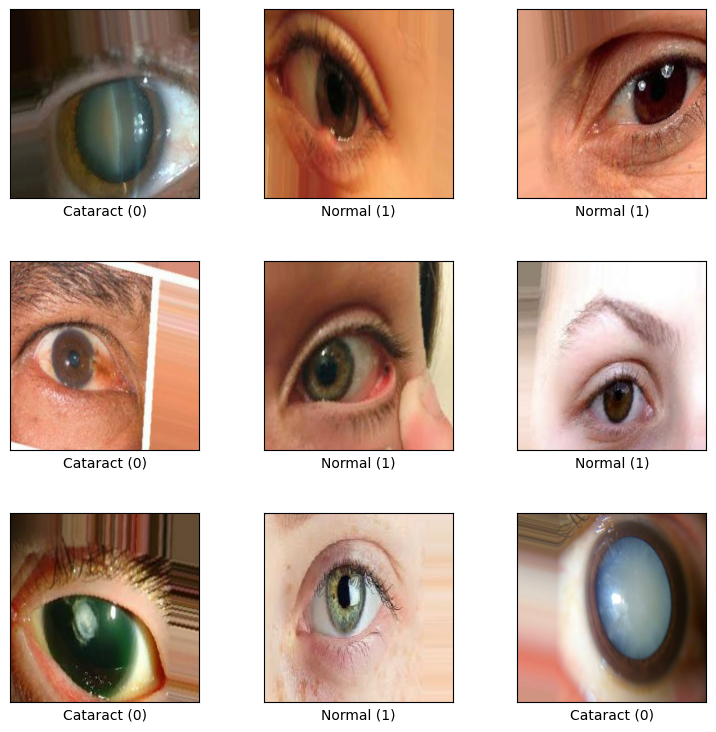

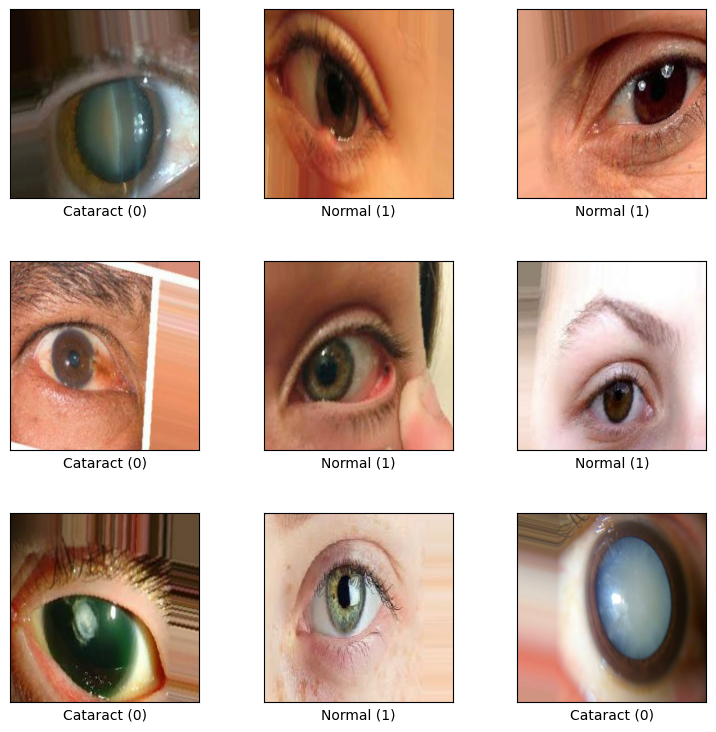

In [ ]:
tfds.show_examples(raw_train, builder.info)

### Format the Data
Shape 160x160, RGB

In [ ]:
IMG_SIZE = 160 #coba ganti 128

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Data augmentation

In [ ]:
train_dir = '/content/images/train'
validation_dir = '/content/images/valid'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary')

Found 6675 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.


### Build model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) #kurangin layer

## Callback

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

### Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

### Train the model


In [ ]:
epochs = 50
validation_steps=20

loss,accuracy = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 4s 76ms/step - loss: 0.6933 - accuracy: 0.5219


In [ ]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

initial loss: 0.69
initial accuracy: 0.52


In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50
209/209 [==============================] - 71s 306ms/step - loss: 0.5740 - accuracy: 0.7010 - val_loss: 0.3771 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/209 [==============================] - 66s 316ms/step - loss: 0.3547 - accuracy: 0.8460 - val_loss: 0.2200 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 3/50
209/209 [==============================] - 59s 285ms/step - loss: 0.2754 - accuracy: 0.8870 - val_loss: 0.1686 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 4/50
209/209 [==============================] - 64s 307ms/step - loss: 0.1948 - accuracy: 0.9236 - val_loss: 0.1515 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/50
209/209 [==============================] - 63s 302ms/step - loss: 0.1684 - accuracy: 0.9371 - val_loss: 0.0923 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 6/50
209/209 [==============================] - 61s 290ms/step - loss: 0.1406 - accuracy: 0.9474 - val_loss: 0.1055 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 7/50
209/209 [==============================] - 63s 303ms/step - loss: 0.1260 - accuracy: 0.9545 - val_loss: 0.0700 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 8/50
209/209 [==============================] - 67s 322ms

### Model Training Visualization

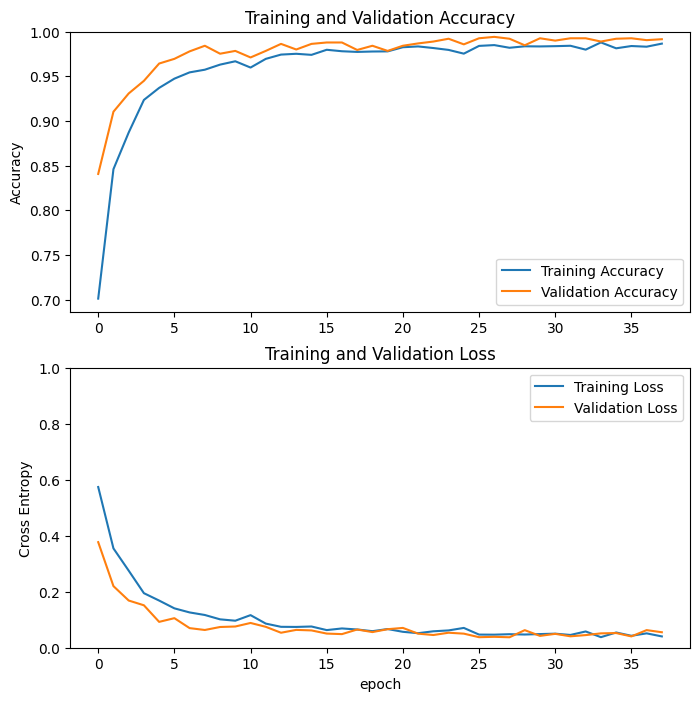

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Prediction Testing

1/1 [==============================] - 0s 430ms/step


Text(0.5, 1.0, 'Normal')

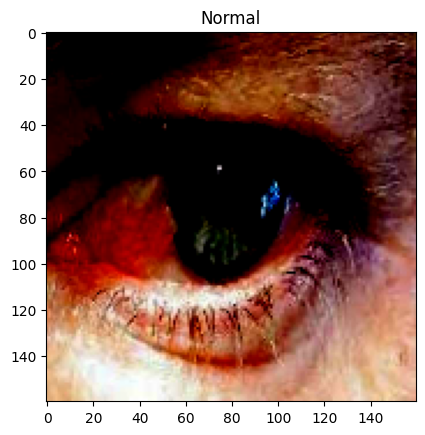

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
plt.imshow(np.squeeze(image))
plt.title("Normal" if model.predict(image) > 0 else "Cataract")

1/1 [==============================] - 0s 34ms/step


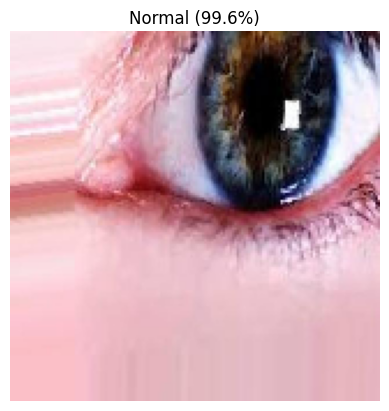

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

folder_path = '/content/images/test/Cataract'
folder_path = '/content/images/test/Normal'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

random_image_path = random.choice(image_files)
image = tf.keras.preprocessing.image.load_img(random_image_path, target_size=(160, 160))
# image = tf.keras.preprocessing.image.load_img('/content/Human_eye_with_limbal_ring,_anterior_view.jpg', target_size=(160, 160)) # kalo mau nyoba pake gambar sendiri

# Preprocess
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array /= 255.0

# Predik
prediction = model.predict(image_array)[0]

confidence = prediction[0]
label = "Normal" if confidence > 0.5 else "Cataract"
confidence_rate = confidence if confidence > 0.5 else 1 - confidence

# Display
plt.imshow(image)
plt.title(f"{label} ({confidence_rate*100:.1f}%)")
plt.axis('off')
plt.show()


In [ ]:
#converter
!tensorflowjs_converter --input_format=keras ./best_model.h5 ./model_json
#compress
!zip -r compressed.zip ./model_json

2024-06-09 06:23:48.795292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  adding: model_json/ (stored 0%)
  adding: model_json/group1-shard3of5.bin (deflated 7%)
  adding: model_json/group1-shard4of5.bin (deflated 7%)
  adding: model_json/group1-shard2of5.bin (deflated 7%)
  adding: model_json/group1-shard1of5.bin (deflated 7%)
  adding: model_json/model.json (deflated 85%)
  adding: model_json/group1-shard5of5.bin (deflated 7%)
